In [192]:
import geopandas as gpd
import geemap
import pandas as pd
import numpy as np
import ee
import re
import plotnine as p9
import sys

        fid        lat        lon
0      bd_1  26.040812  88.684923
1     bd_10  26.041705  88.689806
2    bd_100  26.085165  88.537255
3    bd_101  26.034173  88.699536
4    bd_102  26.034205  88.690657
..      ...        ...        ...
497   bd_95  26.084417  88.534232
498   bd_96  26.083955  88.535327
499   bd_97  26.084664  88.534299
500   bd_98  26.084911  88.534348
501   bd_99  26.083841  88.537574

[502 rows x 3 columns]


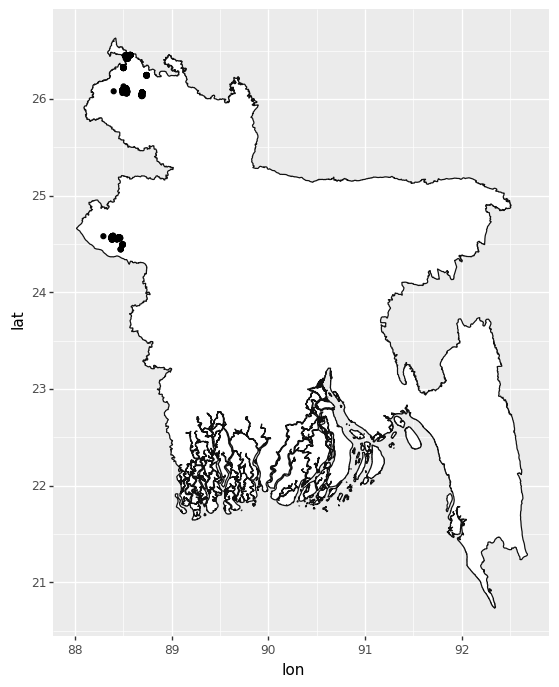

<ggplot: (681617107)>

In [238]:
bd = pd.read_csv('data/survey_bd_josh.csv')
bd_long = bd.melt(id_vars=['fid','country'],value_vars = ['Corner1','Corner2','Corner3','Corner4'])
# bd_long['lat'] = 1
bd_long['value'] = [re.sub('.*([0-9]),([0-9]).*','\\1.\\2',str(x)) for x in bd_long['value']]
bd_long['lat'] = [float(re.sub('^[NE][\\:\\.;\\"]*([0-9]+[\\.,]?[0-9]+).*','\\1',str(x))) for x in bd_long['value']]
bd_long['lon'] = [float(re.sub('.*[\\.,].*[EN][\\:\\s;]?([0-9]+[\\.,]?[0-9]+).*','\\1',str(x))) for x in bd_long['value']]
# bd_long['lat'] = [x for x in bd_long['value']]
bd_long.loc[bd_long['lat'] > 2000,'lat'] = bd_long.loc[bd_long['lat'] > 2000,'lat'] / 1e6
bd_long = bd_long[(bd_long['lon'] < 2000) & (bd_long['lon'] > 70)]
# bd_long[bd_long['lon'] < 70]

bd_pts = bd_long.groupby('fid').agg({'lat':'mean', 'lon':'mean'}).reset_index()
print(bd_pts)
bgd = gpd.read_file('/Users/gopal/Projects/GangesBrahmaputraProject/gbb_github/spatial/unmod/gadm/BGD_adm_shp/BGD_adm0.shp')

(p9.ggplot() +
 p9.geom_map(data = bgd, mapping = p9.aes(), fill = 'white') + 
 p9.geom_point(data = bd_pts,mapping = p9.aes('lon','lat')) +
 p9.coord_equal())

## Prepare Nepal data

In [381]:
npl = pd.read_excel('data/Nepal_GPS.xlsx')
npl['enucode'] = npl['enucode'].ffill()
# npl_csv = pd.read_csv('data/survey_npl_josh.csv')
# npl_csv = npl_csv[['enucode','fid']]
npl
# npl_full = pd.merge(npl, npl_csv, how = 'inner', on = 'enucode')
# [x for x in np.unique(npl['enucode'])]
# list(np.unique(npl_full['enucode']))

,enucode,Longitude,Latitude
0,SB 24,81.608410,28.106454
1,SB 24,81.608932,28.107050
2,SB 24,81.609248,28.106885
3,SB 24,81.608887,28.106223
4,Sb 30,81.609807,28.126086
...,...,...,...
1960,SC71,28.052381,81.845502
1961,SC71,28.051502,81.844999
1962,SC72,28.073032,81.744204
1963,SC72,28.051550,81.844768


In [366]:
a = ['a','b','c']
b = ['a','d','c','e']
[x in a for x in b]

[True, False, True, False]

fixed points:
        enucode       fid_prep        lat        lon          fid
112    GJ 19\n    npl_GJ_19\n  27.755069  83.046977    npl_GJ_19
125    Gj 22\n    npl_Gj_22\n  27.756659  83.047866    npl_Gj_22
310  SB 62 (a)  npl_SB_62_(a)  28.052746  81.751656  npl_SB_62_a
462  Sb 62 (b)  npl_Sb_62_(b)  28.053072  81.751658  npl_Sb_62_b

npl_pts:
              fid        lat        lon  enucode
0      npl_BK__1  27.637465  83.094486    BK  1
1     npl_BK__10  27.610650  83.089365   BK  10
2     npl_BK__11  27.610475  83.088927   BK  11
3    npl_BK__37a  27.748786  83.038633  BK  37a
4     npl_BK__60  27.542246  83.138701   BK  60
..           ...        ...        ...      ...
490    npl_SsN16  28.134967  81.651149    SsN16
491    npl_SsN17  28.135413  81.651845    SsN17
492   npl_SsN21A  28.139636  81.657121   SsN21A
493    npl_SsN57  28.191842  81.534795    SsN57
494    npl_sSN81  28.051354  81.837130    sSN81

[495 rows x 4 columns]


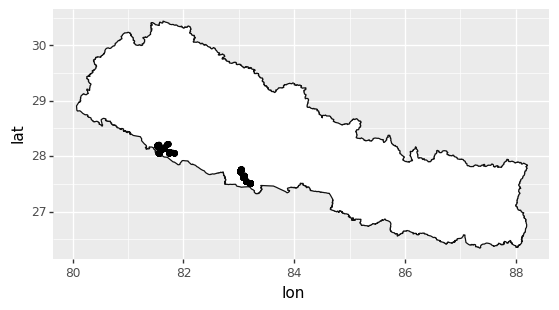

<ggplot: (679354609)>

In [386]:
npl['fid_prep'] = ['npl_' + re.sub(" ","_",x) for x in npl['enucode']]
npl['Latitude'] >40
npl['lat'] = npl['Latitude'].where(npl['Latitude'] < 40,npl['Longitude'])
npl['lon'] = npl['Longitude'].where(npl['Latitude'] < 40,npl['Latitude'])
npl
npl_long = npl
npl_long

npl_pts = npl_long.groupby(['enucode','fid_prep']).agg({'lat':'mean', 'lon':'mean'}).reset_index()
npl_pts['fid'] = [re.sub('[\s\n\.\(\)]', '', x) for x in npl_pts['fid_prep']]
print('fixed points:\n',npl_pts[npl_pts.fid != npl_pts.fid_prep])

# npl_pts = npl_pts.rename(columns={'fid':'enucode','fid_prep':'fid'})
npl_pts = npl_pts[['fid','lat','lon','enucode']]
print('\nnpl_pts:\n',npl_pts)
npl_shp = gpd.read_file('/Users/gopal/Projects/GangesBrahmaputraProject/gbb_github/spatial/unmod/gadm/NPL_adm_shp/NPL_adm0.shp')

(p9.ggplot() +
 p9.geom_map(data = npl_shp, mapping = p9.aes(), fill = 'white') + 
 p9.geom_point(data = npl_pts,mapping = p9.aes('lon','lat')) +
 p9.coord_equal())

In [342]:
# a = np.arange(10)
# b = np.array([3,100,3,3,3,3,500,-500,3,3])
# # list(zip(a,b))
# [x if x < y else y for (x,y) in zip(a,b)]

[0, 1, 2, 3, 3, 3, 6, -500, 3, 3]

## Prepare India data

vartype      fid        lat        lon
0          ind_1  24.582302  84.840557
1         ind_10  24.584104  84.845310
2        ind_100  24.592718  85.013090
3        ind_101  24.592399  85.013080
4        ind_102  24.595206  85.015943
..           ...        ...        ...
750       ind_95  24.599183  85.013326
751       ind_96  24.594583  85.010652
752       ind_97  24.591904  85.013204
753       ind_98  24.595028  85.015233
754       ind_99  24.594837  85.009813

[752 rows x 3 columns]


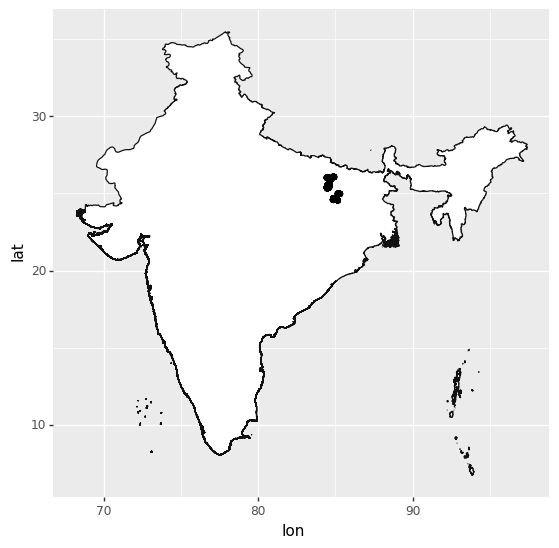

<ggplot: (679264250)>

In [242]:
ind = pd.read_csv('data/survey_ind_josh.csv')
ind_columns = ind.columns
gps_columns = [x for x in ind_columns if 'GPS_Corner' in x]
ind_long = ind.melt(id_vars=['fid','country'],value_vars = gps_columns)
ind_long['value'] = pd.to_numeric(ind_long['value'], errors = 'coerce')
ind_long.dropna()
ind_long['vartype'] = [re.sub('GPS_Corner.*\\-([a-zA-Z]+$)','\\1',x) for x in ind_long.variable]
ind_pts_long = ind_long.groupby(['fid','country','vartype']).agg('mean').reset_index()
ind_pts = ind_pts_long.pivot(index = ['fid'],columns = 'vartype', values = 'value')
ind_pts = ind_pts.reset_index().rename(columns = {'Latitude':'lat', 'Longitude':'lon'})
ind_pts = ind_pts[(ind_pts.lat < 30) & (ind_pts.lat > 22.5)]
print(ind_pts)
ind_shp = gpd.read_file('/Users/gopal/Projects/GangesBrahmaputraProject/gbb_github/spatial/unmod/gadm/IND_adm_shp/IND_adm0.shp')

(p9.ggplot() +
 p9.geom_map(data = ind_shp, mapping = p9.aes(), fill = 'white') + 
 p9.geom_point(data = ind_pts,mapping = p9.aes('lon','lat')) +
 p9.coord_equal())

## Combine points into single df

In [388]:
survey_dir_path = '/Users/gopal/Google Drive/_Research/Research projects/G_D/survey_pts'

survey_pts = pd.concat([bd_pts, ind_pts, npl_pts])
survey_pts.to_csv(os.path.join(survey_dir_path, 'survey_pts_key.csv'), index = False)
survey_pts

,fid,lat,lon,enucode
0,bd_1,26.040812,88.684923,NaN
1,bd_10,26.041705,88.689806,NaN
2,bd_100,26.085165,88.537255,NaN
3,bd_101,26.034173,88.699536,NaN
4,bd_102,26.034205,88.690657,NaN
...,...,...,...,...
490,npl_SsN16,28.134967,81.651149,SsN16
491,npl_SsN17,28.135413,81.651845,SsN17
492,npl_SsN21A,28.139636,81.657121,SsN21A
493,npl_SsN57,28.191842,81.534795,SsN57


## Function to download sentinel 2 and Landsat 8 points

In [255]:
def DownloadS2pt(sample_pt_xy, loc_id, timeseries_dir_path, date_range):
    
    sample_pt_name = 'pt_ts_' + str(loc_id)
    
    sample_pt = ee.Geometry.Point(sample_pt_xy)
    
    timeseries_dir_name = Path(timeseries_dir_path).parts[-1]
    s2_colname = 'pt_ts_loc_s2'
    s2_pt_filename = re.sub('loc_', 'loc_' + str(loc_id) +'_', s2_colname) #sample_pt_name + '_s2'
    s2_pt_filepath = os.path.join(timeseries_dir_path, s2_pt_filename + '.csv')
    
    if os.path.exists(s2_pt_filepath):
        dummy = s2_pt_filepath
        print(s2_pt_filename + '.csv already exists')
        
    else:
    
        s2_output_bands = ['B8','B4','B3','B2','clouds','cloudmask','shadows','probability']
        
        # params variable is used to pass  information to the cloud masking functions.
        # see help(add_cld_shadow_mask_func)
        s2params = {
            'START_DATE' : date_range[0],
            'END_DATE' : date_range[1],
            'CLOUD_FILTER' : 50,
            'CLD_PRB_THRESH' : 53, # 53 for Cauvery # 55 for Indus
            'NIR_DRK_THRESH' : 0.2,
            'CLD_PRJ_DIST' : 1,
            'BUFFER' : 50
        }
        
        s2_clouds_ic = ees.get_s2_sr_cld_col(sample_pt, s2params) \
          .map(ees.add_cld_shadow_mask_func(s2params))
        
        # For some reason the reproject() works so that subsequent sampling returns the whole rectangular array
        # see https://stackoverflow.com/questions/64012752/gee-samplerectangle-returning-1x1-array
        # s2_clouds_im = s2_clouds_ic.mosaic().reproject(crs = ee.Projection('EPSG:4326'), scale=10) #.clip(hyd_watershed)
        
        # Get pixel timeseries
        s2_ts = rs.get_pixel_ts_allbands(
            pts_fc = ee.FeatureCollection(sample_pt),
            image_collection = s2_clouds_ic,
            ic_property_id = 'system:index',
            scale = 10) # for Landsat resolution
        # time_series_pd_load = geemap.ee_to_pandas(time_series_fc)
            
        task_s2 = ee.batch.Export.table.toDrive(
            collection = s2_ts,
            selectors = s2_output_bands + ['image_id'],
            folder = timeseries_dir_name,
            description = s2_pt_filename,
            fileNamePrefix = s2_pt_filename)
        
        task_s2.start()
        
        
        print('Generating ' + s2_pt_filename + '.csv')
        
def DownloadOLI8pt(sample_pt_xy, loc_id, timeseries_dir_path, date_range):
    
    sample_pt_name = 'pt_ts_' + str(loc_id)
    
    sample_pt = ee.Geometry.Point(sample_pt_xy)
    
    timeseries_dir_name = Path(timeseries_dir_path).parts[-1]
    oli8_colname = 'pt_ts_loc_oli8'
    oli8_pt_filename = re.sub('loc_', 'loc_' + str(loc_id) +'_', oli8_colname) #sample_pt_name + '_oli8'
    oli8_pt_filepath = os.path.join(timeseries_dir_path, oli8_pt_filename + '.csv')
    
    if os.path.exists(oli8_pt_filepath):
        print(oli8_pt_filepath + ' already exists')

    else:
        
        oli8_output_bands = ['SR_B7','SR_B6','SR_B5','SR_B4','SR_B3','SR_B2','clouds','shadows','clouds_shadows']
        oli8_ic = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
          .filterBounds(sample_pt) \
          .filterDate(date_range[0],date_range[1])
          
        get_qaband_clouds_shadows = rs.get_qaband_clouds_shadows_func(
              qa_bandname = 'QA_PIXEL', 
              cloud_bit = 3, 
              shadow_bit = 4,
              keep_orig_bands = True) 
        oli8_clouds_ic = (oli8_ic
          .map(get_qaband_clouds_shadows))
          # .map(lambda im: im.addBands(im.expression('im.clouds | im.clouds_shadows', {'im' : im}).rename('cloudmask'))))
          
        # Get oli8 pixel timeseries
        oli8_ts = rs.get_pixel_ts_allbands(
            pts_fc = ee.FeatureCollection(sample_pt),
            image_collection = oli8_clouds_ic,
            ic_property_id = 'system:index',
            scale = 30) # for Landsat resolution
        # time_series_pd_load = geemap.ee_to_pandas(time_series_fc)
    
        # oli8_output_bands = ['B8','B4','B3','B2','clouds','cloudmask','shadows','probability']
        
        
        # For some reason the reproject() works so that subsequent sampling returns the whole rectangular array
        # see https://stackoverflow.com/questions/64012752/gee-samplerectangle-returning-1x1-array
        # oli8_clouds_im = oli8_clouds_ic.mosaic().reproject(crs = ee.Projection('EPSG:4326'), scale=10) #.clip(hyd_watershed)
        
            
        task_oli8 = ee.batch.Export.table.toDrive(
            collection = oli8_ts,
            selectors = oli8_output_bands + ['image_id'],
            folder = timeseries_dir_name,
            description = oli8_pt_filename,
            fileNamePrefix = oli8_pt_filename)
        
        task_oli8.start()
                
        # print('Generating ' + oli8_pt_filename + '.csv')
        print('Generating ' + oli8_pt_filename + '.csv')

In [129]:
sys.path.append('/Users/gopal/Projects/ml/manclassify')
from geemodules import rs
from geemodules import eesentinel as ees
from pathlib import Path
import os

In [124]:
ee.Initialize()

In [324]:
timeseries_dir_path = '/Users/gopal/Google Drive/_Research/Research projects/G_D/survey_pts/mig_survey_GEE'
date_range = ['2012-06-01','2022-06-01']

num_pts = survey_pts.shape[0]

for i in np.arange(1062, num_pts):
    sample_pt_xy = [survey_pts.lon.iloc[i],survey_pts.lat.iloc[i]]
    loc_id = survey_pts.fid.iloc[i]
    # print(f'{i+1} of {num_pts} pts, location id: {loc_id}')
    # DownloadOLI8pt(sample_pt_xy, loc_id, timeseries_dir_path, date_range)
    # DownloadS2pt(sample_pt_xy, loc_id, timeseries_dir_path, date_range)

In [278]:
my_new_string = re.sub('[\s\n\.]', '', loc_id)
# loc_id
my_new_string

'npl_GJ_19'

In [264]:
print(f'{1+1} of 4')
1

2 of 4


1